In [28]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from data.Dataset import StressDataset
from data.DataModules import ERPDataModule
from models import SSL_EEG, EEG_ERP
from modules.decoders import ERP_decoder, MaskedDecoder
from modules.encoders import Conv1DNet, TSTransformerEncoder
from modules.loss import MaskedMSELoss

In [29]:
checkpoints = os.path.join(os.getcwd(), 'stress_checkpoints')  
prueba = os.path.join(checkpoints, 'ckpt-epoch=49-train_f1=0.86-4s.ckpt')
ckpt = os.path.join('checkpoints', 'SSL-1s-val_loss=0.08-epoch=99.ckpt')

# Load the model from the checkpoint
pretrain = SSL_EEG.load_from_checkpoint(ckpt, decoder = MaskedDecoder(d_model=64, feat_dim=8), loss_fn= MaskedMSELoss)

In [30]:
model = EEG_ERP.load_from_checkpoint(prueba, learning_rate = 0.001, convnet = pretrain.covnet, encoder = pretrain.encoder, decoder = ERP_decoder(128,64))

In [31]:
checkpoint = torch.load(prueba)

# # Extract the convnet and encoder state_dict from the checkpoint
# convnet_state_dict = checkpoint['convnet_state_dict']
# encoder_state_dict = checkpoint['encoder_state_dict']

# # Initialize your pre-trained components
# pretrain.convnet.load_state_dict(convnet_state_dict)
# pretrain.encoder.load_state_dict(encoder_state_dict)

# Initialize the EEG_ERP model with the pre-trained components and new decoder
# model = EEG_ERP(
#     learning_rate=0.0001, 
#     convnet=pretrain.covnet, 
#     encoder=pretrain.encoder, 
#     decoder=ERP_decoder(64, 512)
# )

# # Load the rest of the model's state dict
# model.load_state_dict(checkpoint['state_dict'], strict=False)

In [32]:
eeg = os.path.join(os.getcwd(), 'data/deap_stress_1s_subject.h5')
masked_dataset = StressDataset(data_path=eeg, normalize='normalization')
# Create the data module with batch_size from wandb.config)
datamodule = ERPDataModule(dataset = masked_dataset,
    batch_size=32,
    )

In [33]:
datamodule.setup()
validation = datamodule.test_dataloader()
# Test the model
#model.eval()
model.to(model.device)
y_true = []
y_pred = []
for x, y in validation:
    x = x.to(model.device)
    y_hat = model(x)
    predicted_proba = torch.sigmoid(y_hat).detach().cpu().numpy()
    y_true.extend(y.cpu().numpy())
    y_pred.extend(predicted_proba)

Train: 12480 Val: 2820 Test: 900


In [34]:
print(y_true)
print(y_pred)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

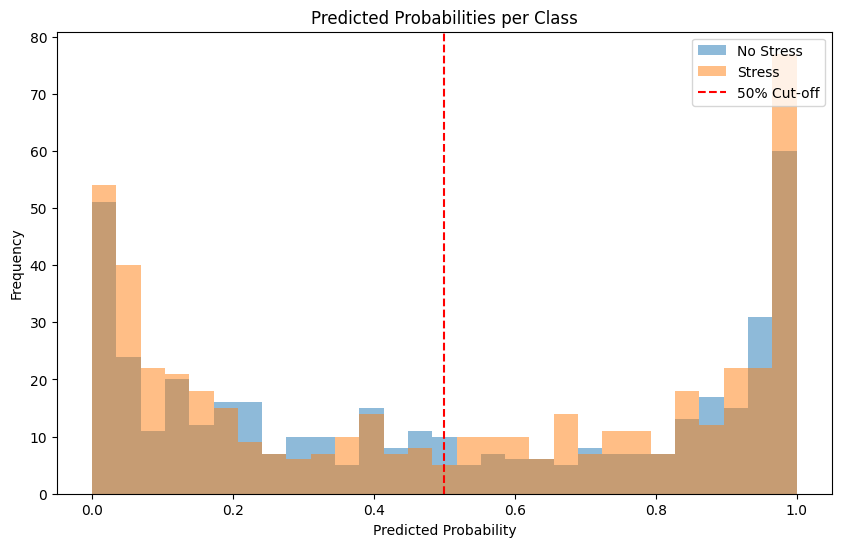

In [35]:
probabilities = np.array(y_pred)
actual_labels = np.array(y_true)

# Separate the probabilities based on the actual class labels
class_0_probs = probabilities[actual_labels == 0]
class_1_probs = probabilities[actual_labels == 1]

# Create histograms
plt.figure(figsize=(10, 6))

# Plot histogram for class 0
plt.hist(class_0_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='No Stress')

# Plot histogram for class 1
plt.hist(class_1_probs, bins=np.linspace(0, 1, 30), alpha=0.5, label='Stress')

# Add vertical line at 0.5 (50% cut-off)
plt.axvline(x=0.5, color='red', linestyle='--', label='50% Cut-off')

plt.title('Predicted Probabilities per Class')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right') 

# Show the plot
plt.show()

In [36]:
# Calculate the accuracy
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred = np.round(y_pred)
print(y_true.shape, y_pred.shape)
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(confusion_matrix(y_true, y_pred))

(900,) (900,)
Accuracy: 0.51
F1: 0.5190839694656489
[[221 199]
 [242 238]]
